# Abstract

We use the SUSY dataset and construct a neural network 
classifier, then apply dimensionality reduction via incrememntal PCA and retrain a network of similar architecture on this "reduced" dataset.
(Placeholder, we should probably rewrite this)

# Setup

Import the SUSY dataset

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz

--2021-04-24 21:10:38--  https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 922377711 (880M) [application/x-httpd-php]
Saving to: ‘SUSY.csv.gz’

SUSY.csv.gz         100%[===================>] 879.65M  90.4MB/s    in 10s     

2021-04-24 21:10:48 (86.6 MB/s) - ‘SUSY.csv.gz’ saved [922377711/922377711]



In [ ]:
!gzip -d SUSY.csv.gz

In [ ]:
import pandas as pd
data = pd.read_csv('./SUSY.csv')

Define X and y as a subset of SUSY.csv (or the entire dataset, commented)


In [ ]:
#All features: 8 low-level, 10 high-level
X=data.iloc[:50000,1:9]
y=data.iloc[:50000,0]

#Full dataset
#X=data.iloc[:,1:]
#y=data.iloc[:,0]

Create the test, train, and validation sets from X and y

In [ ]:
from sklearn.model_selection import train_test_split

X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)

# Neural Network

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import time

In [ ]:
num_dims = (np.shape(X_train))[1]
print(num_dims)

8


Everytime we create a model, we will call this function, create_model(). This way, every model will have the same architecture after the input layer.

In [ ]:
from keras.layers import BatchNormalization

def create_model():
  model = keras.models.Sequential()
  model.add(Dense(300, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(300, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(300, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(300, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(1, activation='sigmoid'))
  return model

Here we define the optimizer which we will use with all models.

In [ ]:
#exp_opt = keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=0.05,
#    decay_steps=10000,
#    decay_rate=1e-5)

opt = keras.optimizers.Adam()


#model.compile(loss='categorical_crossentropy', optimizer=exp_opt)

In [ ]:
model_primary = create_model()
model_primary.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
t1 = time.perf_counter()
model_primary.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=10)
t2 = time.perf_counter()
baseline_time = t2-t1

Epoch 1/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4834 - accuracy: 0.7744 - val_loss: 0.4606 - val_accuracy: 0.7888
Epoch 2/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4824 - accuracy: 0.7757 - val_loss: 0.4681 - val_accuracy: 0.7874
Epoch 3/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4792 - accuracy: 0.7738 - val_loss: 0.4632 - val_accuracy: 0.7864
Epoch 4/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4839 - accuracy: 0.7733 - val_loss: 0.4650 - val_accuracy: 0.7859
Epoch 5/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4824 - accuracy: 0.7747 - val_loss: 0.4602 - val_accuracy: 0.7858
Epoch 6/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4828 - accuracy: 0.7728 - val_loss: 0.4691 - val_accuracy: 0.7819
Epoch 7/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4834 - accuracy: 0.7727 - val_loss: 0.4575 - val_ac

In [ ]:
baseline_time

206.18462303499996

Evaluate the performance of the model.

In [ ]:
_, accuracy = model_primary.evaluate(X_test, y_test)

250/250 [==============================] - 1s 2ms/step - loss: 0.4832 - accuracy: 0.7756


In [ ]:
from sklearn.metrics import roc_curve, auc

# Evaluate on validation set
score = model_primary.evaluate(X_val, y_val, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model_primary.predict(X_val)
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model_primary.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model_primary.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

#To use later, comparing to the PCA datasets:

acc_primary = score[1]
roc_auc_primary = roc_auc
loss_primary = score[0]

313/313 [==============================] - 1s 2ms/step - loss: 0.4794 - accuracy: 0.7744

Validation loss / accuracy: 0.4794 / 0.7744
Validation ROC AUC: 0.8549313605005504
250/250 [==============================] - 1s 2ms/step - loss: 0.4832 - accuracy: 0.7756

Test loss / accuracy: 0.4832 / 0.7756
Test ROC AUC: 0.8497857568627452


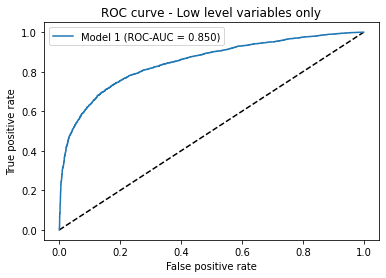

In [ ]:
import matplotlib.pyplot as plt

plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Low level variables only')
plt.legend(loc='best')
plt.show()

PCA


In [ ]:
from sklearn.decomposition import IncrementalPCA


inc_pcas = []
models = []
accuracies = []
aucs = []
losses = []
training_times = []

n_batches=100

cutoff = 7  #The maximum number of reduced dimensions we'll look at.
assert((0 < cutoff) and (cutoff < num_dims))

for d in range(1, cutoff+1):
  
  inc_pca = IncrementalPCA(n_components=d)
  for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
  inc_pcas.append(inc_pca)

  X_train_reduced = inc_pca.transform(X_train)
  X_val_reduced = inc_pca.transform(X_val)
  X_test_reduced = inc_pca.transform(X_test)

  model_reduced = create_model()
  model_reduced.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  
  t1 = time.perf_counter()
  model_reduced.fit(X_train_reduced, y_train, validation_data=(X_val_reduced, y_val), epochs=20, batch_size=10)
  t2 = time.perf_counter()
  training_times.append(t2-t1)

  models.append(model_reduced)

  loss, accuracy = model_reduced.evaluate(X_test_reduced, y_test)
  accuracies.append(accuracy)
  losses.append(loss)

  y_pred_reduced = model_reduced.predict(X_test_reduced)
  fpr, tpr, _ = roc_curve(y_test, y_pred_reduced)
  roc_auc = auc(fpr, tpr)  
  aucs.append(roc_auc)


Epoch 1/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.7282 - accuracy: 0.5224 - val_loss: 0.7016 - val_accuracy: 0.5092
Epoch 2/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.6958 - accuracy: 0.5288 - val_loss: 0.6979 - val_accuracy: 0.5170
Epoch 3/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.6929 - accuracy: 0.5270 - val_loss: 0.6904 - val_accuracy: 0.5389
Epoch 4/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.6919 - accuracy: 0.5309 - val_loss: 0.6895 - val_accuracy: 0.5378
Epoch 5/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.6911 - accuracy: 0.5341 - val_loss: 0.6937 - val_accuracy: 0.5342
Epoch 6/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.6893 - accuracy: 0.5298 - val_loss: 0.6869 - val_accuracy: 0.5344
Epoch 7/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.6893 - accuracy: 0.5388 - val_loss: 0.6864 - val_ac

In [ ]:
models.append(model_primary)
accuracies.append(acc_primary)
aucs.append(roc_auc_primary)
losses.append(loss_primary)
training_times.append(baseline_time)

In [ ]:
dims_array = []
for i in range(1, cutoff+2):
  dims_array.append(i)

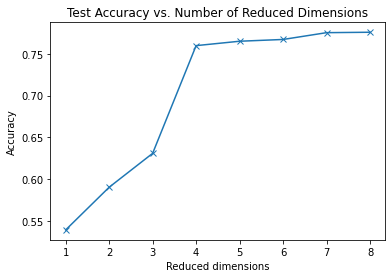

In [ ]:
plt.plot(dims_array, accuracies ,"x-")
plt.xlabel('Reduced dimensions')
plt.ylabel('Accuracy')
plt.xticks(dims_array)
plt.title("Test Accuracy vs. Number of Reduced Dimensions")
plt.show()

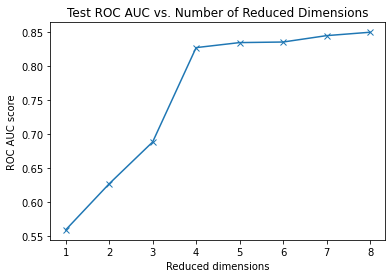

In [ ]:
plt.plot(dims_array, aucs, "x-")
plt.xlabel('Reduced dimensions')
plt.ylabel('ROC AUC score')
plt.xticks(dims_array)
plt.title("Test ROC AUC vs. Number of Reduced Dimensions")
plt.show()

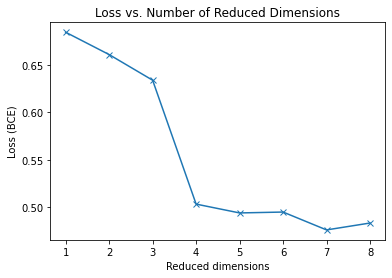

In [ ]:
plt.plot(dims_array, losses,"x-")
plt.xlabel('Reduced dimensions')
plt.ylabel('Loss (BCE)')
plt.xticks(dims_array)
plt.title("Loss vs. Number of Reduced Dimensions")
plt.show()

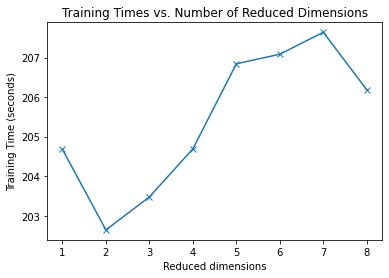

In [ ]:
plt.plot(dims_array, training_times,"x-")
plt.xlabel('Reduced dimensions')
plt.ylabel('Training Time (seconds)')
plt.xticks(dims_array)
plt.title("Training Times vs. Number of Reduced Dimensions")
plt.show()